In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append("/workspaces/MambaLinearCode")
os.chdir("/workspaces/MambaLinearCode")


In [2]:
from configuration import Code, Config
from dataset import get_generator_and_parity
import torch
import os
import logging

def code_from_hint(hint,):
    code_files = os.listdir(CODES_PATH)
    code_files = [f for f in code_files if hint in f][0]
    print(code_files)
    code_n = int(code_files.split('_')[1][1:])
    code_k = int(code_files.split('_')[-1][1:].split('.')[0])
    code_type = code_files.split('_')[0]
    code = Code(code_n, code_k, code_type)
    return code

OUTPUT_PATH = ".semi-working-mamba-mask-large-bidir/.output-8/"
CODES_PATH = "codes/"
example_code = code_from_hint("LDPC_N49_K24")
G,H = get_generator_and_parity(example_code, standard_form=True)
example_code.generator_matrix = torch.from_numpy(G).transpose(0,1).long()
example_code.pc_matrix = torch.from_numpy(H).long()

os.makedirs(OUTPUT_PATH, exist_ok=True)
config = Config(
    code=example_code,
    d_model=128,
    path=OUTPUT_PATH,
    N_dec=8,
    warmup_lr=1.0e-3,
    lr=1e-4,
    epochs=1000,
    eta_min=1e-12
)

handlers = [
        logging.FileHandler(os.path.join(OUTPUT_PATH, 'logging.txt')),
        logging.StreamHandler()
    ]
logging.basicConfig(level=logging.INFO, format='%(message)s',
                    handlers=handlers)

LDPC_N49_K24.alist


In [3]:
from mamba_ssm import Mamba
from dataset import EbN0_to_std, ECC_Dataset, train, test, sign_to_bin, FER, BER, bin_to_sign
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.nn import ModuleList, LayerNorm
import copy
import time
from tqdm import tqdm

import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat

from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, mamba_inner_fn

try:
    from causal_conv1d import causal_conv1d_fn, causal_conv1d_update
except ImportError:
    causal_conv1d_fn, causal_conv1d_update = None, None

try:
    from mamba_ssm.ops.triton.selective_state_update import selective_state_update
except ImportError:
    selective_state_update = None

try:
    from mamba_ssm.ops.triton.layer_norm import RMSNorm, layer_norm_fn, rms_norm_fn
except ImportError:
    RMSNorm, layer_norm_fn, rms_norm_fn = None, None, None

# ECCM
from configuration import Code, Config
import numpy as np

from dataset import sign_to_bin, bin_to_sign
import torch.nn.functional as F
from torch.nn import ModuleList
import copy

def build_mask(code):
    mask_size = code.n + code.pc_matrix.size(0)
    mask = torch.eye(mask_size, mask_size)
    for ii in range(code.pc_matrix.size(0)):
        idx = torch.where(code.pc_matrix[ii] > 0)[0]
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    mask[jj, kk] += 1
                    mask[kk, jj] += 1
                    mask[code.n + ii, jj] += 1
                    mask[jj, code.n + ii] += 1
    src_mask = ~ (mask > 0)
    return src_mask

def mask_larger_matrix(A, mask):
    A[:, :mask.size(0), :mask.size(1)][mask.expand(A.size(0),mask.size(0),mask.size(1))] = 0.0
    A[:, mask.size(0):, mask.size(1):] = 0
    return A

def mask(A,B,C,D, mask):
    B = mask_larger_matrix(B, mask)
    C = mask_larger_matrix(C, mask)
    return A, B, C, D

def mamba_inner_fn(
    xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
    out_proj_weight, out_proj_bias,
    pc_mask, A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
    C_proj_bias=None, delta_softplus=True
):
    assert causal_conv1d_fn is not None, "causal_conv1d_fn is not available. Please install causal-conv1d."
    L = xz.shape[-1]
    delta_rank = delta_proj_weight.shape[1]
    d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
    x, z = xz.chunk(2, dim=1)
    x = causal_conv1d_fn(x, rearrange(conv1d_weight, "d 1 w -> d w"), conv1d_bias, activation="silu")
    # We're being very careful here about the layout, to avoid extra transposes.
    # We want delta to have d as the slowest moving dimension
    # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
    x_dbl = F.linear(rearrange(x, 'b d l -> (b l) d'), x_proj_weight)  # (bl d)
    delta = delta_proj_weight @ x_dbl[:, :delta_rank].t()
    delta = rearrange(delta, "d (b l) -> b d l", l=L)
    if B is None:  # variable B
        B = x_dbl[:, delta_rank:delta_rank + d_state]  # (bl d)
        if B_proj_bias is not None:
            B = B + B_proj_bias.to(dtype=B.dtype)
        if not A.is_complex():
            B = rearrange(B, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            B = rearrange(B, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    if C is None:  # variable B
        C = x_dbl[:, -d_state:]  # (bl d)
        if C_proj_bias is not None:
            C = C + C_proj_bias.to(dtype=C.dtype)
        if not A.is_complex():
            C = rearrange(C, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            C = rearrange(C, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    # mask
    A,B,C,D = mask(A,B,C,D,pc_mask)
    y = selective_scan_fn(x, delta, A, B, C, D, z=z, delta_bias=delta_bias, delta_softplus=True)
    mask_larger_matrix(y, pc_mask)
    return F.linear(rearrange(y, "b d l -> b l d"), out_proj_weight, out_proj_bias)


class ECCMLayer(nn.Module):
    def __init__(
        self,
        code: Code,
        d_model=16,
        d_conv=4,
        expand=1,
        dt_rank="auto",
        dt_min=0.001,
        dt_max=0.1,
        dt_init="random",
        dt_scale=1.0,
        dt_init_floor=1e-4,
        conv_bias=True,
        bias=False,
        use_fast_path=True,  # Fused kernel options
        layer_idx=None,
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.code_length = code.n
        self.output_length = self.code_length + code.pc_matrix.size(0)
        d_state = int(2**np.ceil(np.log2(self.output_length)))
        self.d_model = d_model

        assert self.d_model * expand > self.output_length, f"d_model * expand {self.d_model * expand} must be larger than the output length, (code_length + syndrome length)."
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(self.expand * self.d_model)
        self.dt_rank = math.ceil(self.d_model / 16) if dt_rank == "auto" else dt_rank
        self.use_fast_path = use_fast_path
        self.layer_idx = layer_idx

        self.in_proj = nn.Linear(self.d_model, self.d_inner * 2, bias=bias, **factory_kwargs)

        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            bias=conv_bias,
            kernel_size=d_conv,
            groups=self.d_inner,
            padding=d_conv - 1,
            **factory_kwargs,
        )

        self.activation = "silu"
        self.act = nn.SiLU()

        self.x_proj = nn.Linear(
            self.d_inner, self.dt_rank + self.d_state * 2, bias=False, **factory_kwargs
        )
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True, **factory_kwargs)

        # Initialize special dt projection to preserve variance at initialization
        dt_init_std = self.dt_rank**-0.5 * dt_scale
        if dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # Initialize dt bias so that F.softplus(dt_bias) is between dt_min and dt_max
        dt = torch.exp(
            torch.rand(self.d_inner, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        ).clamp(min=dt_init_floor)
        # Inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        inv_dt = dt + torch.log(-torch.expm1(-dt))
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        # Our initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        self.dt_proj.bias._no_reinit = True

        # S4D real initialization
        A = repeat(
            torch.arange(1, self.d_state + 1, dtype=torch.float32, device=device),
            "n -> d n",
            d=self.d_inner,
        ).contiguous()
        A_log = torch.log(A)  # Keep A_log in fp32
        self.A_log = nn.Parameter(A_log)
        self.A_log._no_weight_decay = True

        # D "skip" parameter
        self.D = nn.Parameter(torch.ones(self.d_inner, device=device))  # Keep in fp32
        self.D._no_weight_decay = True

        self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=bias, **factory_kwargs)

    def forward(self, hidden_states, pc_mask, inference_params=None):
        """
        hidden_states: (B, L, D)
        pc_mask: (L, P)
        Returns: same shape as hidden_states
        """
        batch, seqlen, dim = hidden_states.shape

        conv_state, ssm_state = None, None
        if inference_params is not None:
            conv_state, ssm_state = self._get_states_from_cache(inference_params, batch)
            if inference_params.seqlen_offset > 0:
                # The states are updated inplace
                out, _, _ = self.step(hidden_states, conv_state, ssm_state)
                return out

        # We do matmul and transpose BLH -> HBL at the same time
        xz = rearrange(
            self.in_proj.weight @ rearrange(hidden_states, "b l d -> d (b l)"),
            "d (b l) -> b d l",
            l=seqlen,
        )
        if self.in_proj.bias is not None:
            xz = xz + rearrange(self.in_proj.bias.to(dtype=xz.dtype), "d -> d 1")

        A = -torch.exp(self.A_log.float())  # (d_inner, d_state)
        # In the backward pass we write dx and dz next to each other to avoid torch.cat
        if self.use_fast_path and causal_conv1d_fn is not None and inference_params is None:  # Doesn't support outputting the states
            out = mamba_inner_fn(
                xz,
                self.conv1d.weight,
                self.conv1d.bias,
                self.x_proj.weight,
                self.dt_proj.weight,
                self.out_proj.weight,
                self.out_proj.bias,
                pc_mask,
                A,
                None,  # input-dependent B
                None,  # input-dependent C
                self.D.float(),
                delta_bias=self.dt_proj.bias.float(),
                delta_softplus=True,
            )
        else:
            x, z = xz.chunk(2, dim=1)
            # Compute short convolution
            if conv_state is not None:
                # If we just take x[:, :, -self.d_conv :], it will error if seqlen < self.d_conv
                # Instead F.pad will pad with zeros if seqlen < self.d_conv, and truncate otherwise.
                conv_state.copy_(F.pad(x, (self.d_conv - x.shape[-1], 0)))  # Update state (B D W)
            if causal_conv1d_fn is None:
                x = self.act(self.conv1d(x)[..., :seqlen])
            else:
                assert self.activation in ["silu", "swish"]
                x = causal_conv1d_fn(
                    x=x,
                    weight=rearrange(self.conv1d.weight, "d 1 w -> d w"),
                    bias=self.conv1d.bias,
                    activation=self.activation,
                )

            # We're careful here about the layout, to avoid extra transposes.
            # We want dt to have d as the slowest moving dimension
            # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
            x_dbl = self.x_proj(rearrange(x, "b d l -> (b l) d"))  # (bl d)
            dt, B, C = torch.split(x_dbl, [self.dt_rank, self.d_state, self.d_state], dim=-1)
            dt = self.dt_proj.weight @ dt.t()
            dt = rearrange(dt, "d (b l) -> b d l", l=seqlen)
            B = rearrange(B, "(b l) dstate -> b dstate l", l=seqlen).contiguous()
            C = rearrange(C, "(b l) dstate -> b dstate l", l=seqlen).contiguous()
            assert self.activation in ["silu", "swish"]
            D = self.D.float()
            A,B,C,D = mask(A,B,C,D, pc_mask)
            
            y = selective_scan_fn(
                x,
                dt,
                A,
                B,
                C,
                D,
                z=z,
                delta_bias=self.dt_proj.bias.float(),
                delta_softplus=True,
                return_last_state=ssm_state is not None,
            )
            if ssm_state is not None:
                y, last_state = y
                ssm_state.copy_(last_state)
            y = rearrange(y, "b d l -> b l d")
            mask_larger_matrix(y, pc_mask)
            out = self.out_proj(y)
        return out

    def step(self, hidden_states, conv_state, ssm_state, pc_mask):
        dtype = hidden_states.dtype
        assert hidden_states.shape[1] == 1, "Only support decoding with 1 token at a time for now"
        xz = self.in_proj(hidden_states.squeeze(1))  # (B 2D)
        x, z = xz.chunk(2, dim=-1)  # (B D)

        # Conv step
        if causal_conv1d_update is None:
            conv_state.copy_(torch.roll(conv_state, shifts=-1, dims=-1))  # Update state (B D W)
            conv_state[:, :, -1] = x
            x = torch.sum(conv_state * rearrange(self.conv1d.weight, "d 1 w -> d w"), dim=-1)  # (B D)
            if self.conv1d.bias is not None:
                x = x + self.conv1d.bias
            x = self.act(x).to(dtype=dtype)
        else:
            x = causal_conv1d_update(
                x,
                conv_state,
                rearrange(self.conv1d.weight, "d 1 w -> d w"),
                self.conv1d.bias,
                self.activation,
            )

        x_db = self.x_proj(x)  # (B dt_rank+2*d_state)
        dt, B, C = torch.split(x_db, [self.dt_rank, self.d_state, self.d_state], dim=-1)
        # Don't add dt_bias here
        dt = F.linear(dt, self.dt_proj.weight)  # (B d_inner)
        A = -torch.exp(self.A_log.float())  # (d_inner, d_state)

        D = self.D.float()
        A,B,C,D = mask(A,B,C,D,pc_mask)
            
        # SSM step
        if selective_state_update is None:
            # Discretize A and B
            dt = F.softplus(dt + self.dt_proj.bias.to(dtype=dt.dtype))
            dA = torch.exp(torch.einsum("bd,dn->bdn", dt, A))
            dB = torch.einsum("bd,bn->bdn", dt, B)
            ssm_state.copy_(ssm_state * dA + rearrange(x, "b d -> b d 1") * dB)
            y = torch.einsum("bdn,bn->bd", ssm_state.to(dtype), C)
            y = y + D.to(dtype) * x
            y = y * self.act(z)  # (B D)
        else:
            y = selective_state_update(
                ssm_state, x, dt, A, B, C, D, z=z, dt_bias=self.dt_proj.bias, dt_softplus=True
            )

        mask_larger_matrix(y, pc_mask)
        out = self.out_proj(y)
        return out.unsqueeze(1), conv_state, ssm_state

    def allocate_inference_cache(self, batch_size, max_seqlen, dtype=None, **kwargs):
        device = self.out_proj.weight.device
        conv_dtype = self.conv1d.weight.dtype if dtype is None else dtype
        conv_state = torch.zeros(
            batch_size, self.d_model * self.expand, self.d_conv, device=device, dtype=conv_dtype
        )
        ssm_dtype = self.dt_proj.weight.dtype if dtype is None else dtype
        # ssm_dtype = torch.float32
        ssm_state = torch.zeros(
            batch_size, self.d_model * self.expand, self.d_state, device=device, dtype=ssm_dtype
        )
        return conv_state, ssm_state

    def _get_states_from_cache(self, inference_params, batch_size, initialize_states=False):
        assert self.layer_idx is not None
        if self.layer_idx not in inference_params.key_value_memory_dict:
            batch_shape = (batch_size,)
            conv_state = torch.zeros(
                batch_size,
                self.d_model * self.expand,
                self.d_conv,
                device=self.conv1d.weight.device,
                dtype=self.conv1d.weight.dtype,
            )
            ssm_state = torch.zeros(
                batch_size,
                self.d_model * self.expand,
                self.d_state,
                device=self.dt_proj.weight.device,
                dtype=self.dt_proj.weight.dtype,
                # dtype=torch.float32,
            )
            inference_params.key_value_memory_dict[self.layer_idx] = (conv_state, ssm_state)
        else:
            conv_state, ssm_state = inference_params.key_value_memory_dict[self.layer_idx]
            # TODO: What if batch size changes between generation, and we reuse the same states?
            if initialize_states:
                conv_state.zero_()
                ssm_state.zero_()
        return conv_state, ssm_state



device = "cuda"

def clones(module, N):
    return ModuleList([copy.deepcopy(module) for _ in range(N)])

def build_mask(code):
    mask_size = code.n + code.pc_matrix.size(0)
    mask = torch.eye(mask_size, mask_size)
    for ii in range(code.pc_matrix.size(0)):
        idx = torch.where(code.pc_matrix[ii] > 0)[0]
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    mask[jj, kk] += 1
                    mask[kk, jj] += 1
                    mask[code.n + ii, jj] += 1
                    mask[jj, code.n + ii] += 1
    src_mask = ~ (mask > 0)
    return src_mask

class EncoderLayer(torch.nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.syndrom_length = config.code.pc_matrix.size(0)
        self.n = config.code.n
        self.register_buffer('pc_mask', build_mask(config.code))
        self.mamba = ECCMLayer(
            code=config.code,
            d_model=config.d_model,
        )
        self.src_embed = torch.nn.Parameter(torch.ones(
            (self.n + self.syndrom_length, config.d_model)))
        # self.up_output_dim = torch.nn.Linear(config.d_model, self.n + self.syndrom_length)
        # self.resize_output_dim = torch.nn.Linear(self.n + self.syndrom_length, 1)
        # self.norm_output = LayerNorm((self.n,))
        self.resize_output_dim = torch.nn.Linear(config.d_model, 1)
    
    def forward(self, x):
        emb: torch.Tensor = self.src_embed.unsqueeze(0) * x
        mamba_forward_out = self.mamba.forward(emb, self.pc_mask)
        mamba_reverse_out = self.mamba.forward(torch.flip(emb,[1]), torch.flip(self.pc_mask, [1]))
        mamba_out = mamba_forward_out + torch.flip(mamba_reverse_out, [1])
        # up_convert_out: torch.Tensor = self.up_output_dim(mamba_out)
        # gated_output = up_convert_out.masked_fill(self.pc_mask.bool(), 0.0)
        # out_dim_corrected: torch.Tensor = self.resize_output_dim(gated_output).squeeze(0)
        out_dim_corrected = self.resize_output_dim(mamba_out)
        return F.tanh(out_dim_corrected)

class ECCM(torch.nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.n = config.code.n
        self.syndrom_length = config.code.pc_matrix.size(0)
        self.mamba: ModuleList = clones(EncoderLayer(config,), config.N_dec)
        self.resize_output_length = torch.nn.Linear(self.n + self.syndrom_length, self.n)

        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)
    
    def forward(self, magnitude, syndrome):
        inp = torch.cat([magnitude, syndrome], -1)
        emb = inp.unsqueeze(-1)
        hidden = emb
        for sublayer in self.mamba:
            hidden: torch.Tensor = sublayer.forward(hidden)
        hidden = emb + hidden
        out = self.resize_output_length(hidden.squeeze(-1))
        return (1-F.tanh(out))/2

    def loss(self, z_pred, z2, y):
        loss = F.binary_cross_entropy(
            z_pred, sign_to_bin(torch.sign(z2)))
        x_pred = sign_to_bin(torch.sign(bin_to_sign(F.tanh(z_pred)) * torch.sign(y)))
        return loss, x_pred


model = ECCM(config=config).to("cuda")


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np


def train(model, device, train_loader, optimizer, epoch, LR, config: Config):
    model.train()
    cum_loss = cum_ber = cum_fer = cum_samples = cum_loss = 0.
    t = time.time()
    batch_idx = 0
    for m, x, z, y, magnitude, syndrome in tqdm(train_loader, position=0, leave=True, desc="Training"):
        z_mul = (y * bin_to_sign(x)) # x = 1, y = -1 => z_mul = -1
        z_pred = model(magnitude.to(device), syndrome.to(device))
        loss, x_pred = model.loss(z_pred, z_mul.to(device), y.to(device))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        ###
        ber = BER(x_pred, x.to(device))
        fer = FER(x_pred, x.to(device))

        cum_loss += loss.item() * x.shape[0]
        cum_ber += ber * x.shape[0]
        cum_fer += fer * x.shape[0]
        cum_samples += x.shape[0]
        if batch_idx == len(train_loader) - 1:
            logging.info(
                f'Training epoch {epoch}, Batch {batch_idx + 1}/{len(train_loader)}: LR={LR:.2e}, Loss={cum_loss / cum_samples:.2e} BER={cum_ber / cum_samples:.2e} FER={cum_fer / cum_samples:.2e}')
        batch_idx += 1
    logging.info(f'Epoch {epoch} Train Time {time.time() - t}s\n')
    return cum_loss / cum_samples, cum_ber / cum_samples, cum_fer / cum_samples

def test(model, device, test_loader_list, EbNo_range_test, min_FER=100):
    model.eval()
    t = time.time()
    with torch.no_grad():
        for ii, test_loader in enumerate(test_loader_list):
            test_loss = test_ber = test_fer = cum_count = 0.
            for m, x, z, y, magnitude, syndrome in tqdm(test_loader, position=0, leave=True, desc="Testing"):
                z_mul = (y * bin_to_sign(x))
                z_pred = model(magnitude.to(device), syndrome.to(device))
                loss, x_pred = model.loss(z_pred, z_mul.to(device), y.to(device))

                test_loss += loss.item()

                test_ber += BER(x_pred, x.to(device))
                test_fer += FER(x_pred, x.to(device))
            ln_ber = -np.log(test_ber)
            logging.info(f'Test EbN0={EbNo_range_test[ii]}, BER={test_ber:.2e} -ln(BER)={ln_ber:.2e}')

def train_model(args: Config, model: torch.nn.Module):
    code = args.code
    initial_lr = args.warmup_lr
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = Adam(model.parameters(), lr=args.warmup_lr)

    # model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
    # optimizer.load_state_dict(torch.load(os.path.join(config.path, 'optimizer_checkpoint')))
    

    #################################
    EbNo_range_test = range(0, 10)
    EbNo_range_train = range(2, 8)
    std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
    std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
    train_dataloader = DataLoader(ECC_Dataset(code, std_train, len=args.batch_size * 1000, zero_cw=False), batch_size=int(args.batch_size),
                                  shuffle=True, num_workers=args.workers)
    test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(args.test_batch_size), zero_cw=False),
                                       batch_size=int(args.test_batch_size), shuffle=False, num_workers=args.workers) for ii in range(len(std_test))]
    #################################

    best_loss = float('inf')
    for epoch in range(1,10):
        loss, ber, fer = train(model, device, train_dataloader, optimizer,
                               epoch, LR=initial_lr, config=args)
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
    test(model, device, test_dataloader_list, EbNo_range_test)
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = args.lr
    
    scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=args.eta_min)
    # scheduler.load_state_dict(torch.load(os.path.join(config.path, 'scheduler_checkpoint')))

    snr_step = 0
    for epoch in range(10, args.epochs + 1):
        # if best_loss < 2e-2:
        #     print("snr_step: ", snr_step)
        #     snr_step += 3
        #     best_loss = float('inf')
        #     EbNo_range_train = range(5-snr_step, 8)
        #     std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
        #     train_dataloader = DataLoader(ECC_Dataset(code, std_train, len=args.batch_size * 1000, zero_cw=False), batch_size=int(args.batch_size),
        #                             shuffle=True, num_workers=args.workers)
        loss, ber, fer = train(model, device, train_dataloader, optimizer,
                               epoch, LR=scheduler.get_last_lr()[0], config=args)
        scheduler.step()
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
            torch.save(optimizer.state_dict(), os.path.join(args.path, 'optimizer_checkpoint'))
            torch.save(scheduler.state_dict(), os.path.join(args.path, 'scheduler_checkpoint'))

        if epoch % 10 == 0:
            test(model, device, test_dataloader_list, EbNo_range_test)
    return model

# with torch.amp.autocast("cuda", enabled=False):
train_model(config, model)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:  34%|███▍      | 342/1000 [08:39<16:35,  1.51s/it]

In [5]:

model = ECCM(config=config)
model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
model = model.to("cuda")

/tmp/ipykernel_781/2858039931.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))


In [8]:
from dataset import bin_to_sign
import numpy as np
code = config.code
# EbNo_range_test = range(0, 10)
EbNo_range_test = [2,3,4,5,6,7,8,9,10]
std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(config.test_batch_size), zero_cw=False),
                                       batch_size=int(config.test_batch_size), shuffle=False, num_workers=config.workers) for ii in range(len(std_test))]
model.eval()
t = time.time()
with torch.no_grad():
    for ii, test_loader in enumerate(test_dataloader_list):
        test_loss = test_ber = test_fer = cum_count = 0.
        for m, x, z, y, magnitude, syndrome in tqdm(test_loader, position=0, leave=True, desc="Testing"):
            z_mul = (y * bin_to_sign(x))
            z_pred = model(y.to(device), syndrome.to(device))
            loss, x_pred = model.loss(z_pred, z_mul.to(device), y.to(device))

            test_loss += loss.item()

            test_ber += BER(x_pred, x.to(device))
            test_fer += FER(x_pred, x.to(device))
            # break
        ln_ber = -np.log(test_ber)
        logging.info(f'Test EbN0={EbNo_range_test[ii]}, BER={test_ber:.2e} -ln(BER)={ln_ber:.2e} loss={loss:.2e}')
        # break



Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Testing: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Test EbN0=2, BER=4.04e-01 -ln(BER)=9.05e-01 loss=2.67e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
Test EbN0=3, BER=3.73e-01 -ln(BER)=9.86e-01 loss=2.26e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
Test EbN0=4, BER=3.35e-01 -ln(BER)=1.09e+00 loss=1.82e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Test EbN0=5, BER=3.02e-01 -ln(BER)=1.20e+00 loss=1.49e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Test EbN0=6, BER=2.78e-01 -ln(BER)=1.28e+00 loss=1.26e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
Test EbN0=7, BER=2.48e-01 -ln(BER)=1.40e+00 loss=1.08e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Test EbN0=8, BER=2.37e-01 -ln(BER)=1.44e+00 loss=1.02e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
Test EbN0=9, BER=2.18e-01 -ln(BER)=1.52e+00 loss=9.07e-01
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Test EbN0=10, BER=2.22e-01 -ln(BER)=1.50e

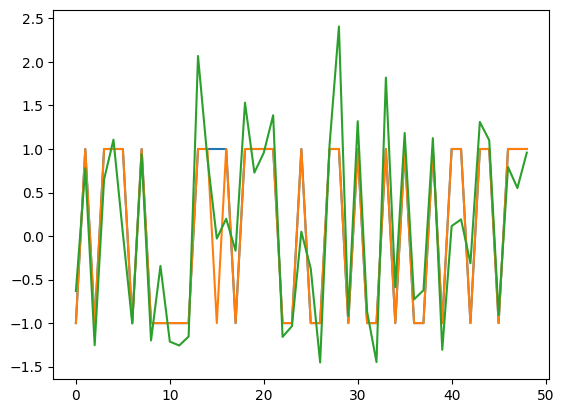

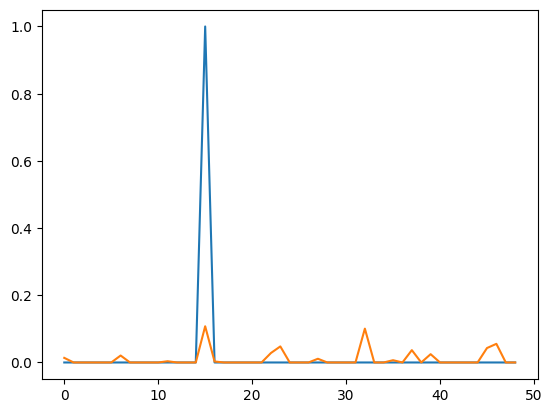

In [10]:
from matplotlib import pyplot as plt
z_pred = model(y.to('cuda'), syndrome.to('cuda'))

plt.figure()
plt.plot(bin_to_sign(x[0]))
plt.plot(bin_to_sign(x_pred[0].cpu().detach().numpy()))
plt.plot(y[0])
# plt.plot(z_mul[0])
plt.figure()
plt.plot(sign_to_bin(torch.sign(z_mul[0])))
plt.plot(z_pred[0].cpu().detach().numpy())

In [25]:
F.binary_cross_entropy(z_pred[0].cpu().detach(), sign_to_bin(torch.sign(z_mul[0])))

tensor(0.0021)

In [23]:
z_pred = model(y.to('cuda'), syndrome.to('cuda'))
print("z_mul", z_mul)
print("z_pred", z_pred)
loss, x_pred = model.loss(-z_pred, z_mul.to('cuda'), y.to('cuda'))
loss

z_mul tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])
z_pred tensor([[ -4.3801,  -2.9162,  -2.5602,  ...,   1.2051,  -1.0924,   0.9583],
        [-12.9807,  -2.1286,  -5.7694,  ...,  -7.4781,  -9.1298, -12.0499],
        [ -4.4897,  -2.0860,  -4.3824,  ...,  -0.9003,  -1.7773,   0.6461],
        ...,
        [ -9.9376,  -4.6682,  -3.7411,  ...,  -4.3122,  -8.2296,  -8.3354],
        [-10.4801,  -5.5553, -10.1773,  ...,  -5.0134,  -4.5016,  -4.3174],
        [  0.5509, -10.8083,  -7.9406,  ...,  -1.5421,  -3.4090,  -2.8939]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


tensor(6.2975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
# Ideas:
# Bi-directional
# Load and output

In [ ]:
y.shape